### Graded Assignment #3 - Bike Sharing Assignment
This assignment is a programming assignment wherein you have to build a multiple linear regression model for the prediction of demand for shared bikes. 

Business Goal:
You are required to model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market. 

#### Submitted by: Venki Ramachandran, part of Graded Assignments for the course M.Sc in AI/ML

#### Dated: 08th-March-2021

#### Steps to Multi-Linear Regression (MLR)
1. Importing, Reading, understanding and visualizing the data
2. Preparing the data for modeling (train-test split, rescaling etc)
3. Training the model
4. Residual Analysis
5. Predictions and evaluations of the test set
6. Intrepretations and the final model statement
7. What else can be done based on domain knowledge? Derived columns, non-linear relation..

### 1) Importing, Reading, Understanding and Visualizing Data

In [3]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Import all required and necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

In [5]:
# Importing day.csv
day = pd.read_csv('day.csv')

In [6]:
# Looking at the first five rows
day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


#### Column Definitions
- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not 
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [7]:
day.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

#### Data Understanding and Cleaning
Looking at the sample dat, I can understand the following about the data

1. Target variable = cnt (count of total rental bikes)
2. Variable Clasification 
    - Categoroical variables: season, mnth, weekday, weathersit
    - Binary variables: yr, holiday, workingday,
    - Continuous variables: cnt, hum, windspeed
3. Drop unnecessary variables: instant, dteday, casual, registered,atemp (to start with more will come later)
4. Check the data types of all columns and make necessrayt changes

##### Decided to drop the following columns
1. instant - just a index
2. dteday - already data has been extracted and columns month, yr, weekday has been populated
3. casual and registered - do not care why, only care about how many bikes were rented
4. atemp - it is a derivative of the temp column

In [8]:
# DROP the unnecessary variables
day.drop(['instant','dteday','casual','registered','atemp'], axis = 1, inplace = True)
day.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,43.6957,12.522300,1600


### Data Preparation - Convert categorical values to continuous values

In [9]:
day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   hum         730 non-null    float64
 9   windspeed   730 non-null    float64
 10  cnt         730 non-null    int64  
dtypes: float64(3), int64(8)
memory usage: 62.9 KB


In [10]:
# Convert Season
# season : season (1:spring, 2:summer, 3:fall, 4:winter)
day['season']=day['season'].map({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})
# mnth : month ( 1 to 12)
day['mnth']=day['mnth'].map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug'
                           , 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})
# weekday : day of the week
# 01-01-2018 day of week is Monday so that is 6 and Tue = 0 based on the data
day['weekday']=day['weekday'].map({0: 'Tue', 1: 'Wed', 2: 'Tur', 3: 'Fri', 4: 'Sat', 5: 'Sun', 6: 'Mon'})
# weathersit
day['weathersit']=day['weathersit'].map({1: 'Clear', 2: 'Mist', 3: 'LightSnow', 4: 'HeavyRain' })

In [11]:
# Check the dataframe now
day.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,spring,0,Jan,0,Mon,0,Mist,14.110847,80.5833,10.749882,985
1,spring,0,Jan,0,Tue,0,Mist,14.902598,69.6087,16.652113,801
2,spring,0,Jan,0,Wed,1,Clear,8.050924,43.7273,16.636703,1349
3,spring,0,Jan,0,Tur,1,Clear,8.200000,59.0435,10.739832,1562
4,spring,0,Jan,0,Fri,1,Clear,9.305237,43.6957,12.522300,1600


### Dummy Variables
We have four (4) - see above - categorical values and we need to convert the 
number values (whch could be mistaken for actual continuous number values, instead they are labels) to the appropriate categories, get dummy columns, drop the first one
and do that for all these four variables - season, mnth, weekday, weathersit

The variable `season` has four(4) levels. We need to convert these levels into integer as well. For this, we will use something called `dummy variables`.

In [12]:
# Get the dummy variables for the feature 'season' and store it in a new variable - 'status'
status = pd.get_dummies(day['season'])

# Check what the dataset 'status' looks like
status.head()

,fall,spring,summer,winter
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


Now, you don't need four columns. You can drop the `winter` column, as the type of season can be identified with just the last three columns where — 
- `000` will correspond to `fall`
- `100` will correspond to `spring`
- `010` will correspond to `summer`
- `001` will correspond to `winter`

In [13]:
# Let's drop the first column from season df using 'drop_first = True'
status = pd.get_dummies(day['season'], drop_first = True)

# Add the results to the original housing dataframe
day = pd.concat([day, status], axis = 1)

#Now let's see the head of our dataframe.
day.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,spring,summer,winter
0,spring,0,Jan,0,Mon,0,Mist,14.110847,80.5833,10.749882,985,1,0,0
1,spring,0,Jan,0,Tue,0,Mist,14.902598,69.6087,16.652113,801,1,0,0
2,spring,0,Jan,0,Wed,1,Clear,8.050924,43.7273,16.636703,1349,1,0,0
3,spring,0,Jan,0,Tur,1,Clear,8.200000,59.0435,10.739832,1562,1,0,0
4,spring,0,Jan,0,Fri,1,Clear,9.305237,43.6957,12.522300,1600,1,0,0


In [14]:
# Drop 'season' as we have created the dummies for it
day.drop(['season'], axis = 1, inplace = True)
day.head()

,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,spring,summer,winter
0,0,Jan,0,Mon,0,Mist,14.110847,80.5833,10.749882,985,1,0,0
1,0,Jan,0,Tue,0,Mist,14.902598,69.6087,16.652113,801,1,0,0
2,0,Jan,0,Wed,1,Clear,8.050924,43.7273,16.636703,1349,1,0,0
3,0,Jan,0,Tur,1,Clear,8.200000,59.0435,10.739832,1562,1,0,0
4,0,Jan,0,Fri,1,Clear,9.305237,43.6957,12.522300,1600,1,0,0


#### Do the same for 'mnth' column

In [15]:
# Get the dummy variables for the feature 'mnth' and store it in a new variable - 'status'
status = pd.get_dummies(day['mnth'])
# Let's drop the first column from mnth df using 'drop_first = True'
status = pd.get_dummies(day['mnth'], drop_first = True)
# Add the results to the original housing dataframe
day = pd.concat([day, status], axis = 1)
#Now let's see the head of our dataframe.
day.head()

,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,Jan,0,Mon,0,Mist,14.110847,80.5833,10.749882,985,...,0,0,1,0,0,0,0,0,0,0
1,0,Jan,0,Tue,0,Mist,14.902598,69.6087,16.652113,801,...,0,0,1,0,0,0,0,0,0,0
2,0,Jan,0,Wed,1,Clear,8.050924,43.7273,16.636703,1349,...,0,0,1,0,0,0,0,0,0,0
3,0,Jan,0,Tur,1,Clear,8.200000,59.0435,10.739832,1562,...,0,0,1,0,0,0,0,0,0,0
4,0,Jan,0,Fri,1,Clear,9.305237,43.6957,12.522300,1600,...,0,0,1,0,0,0,0,0,0,0


In [16]:
day.columns

Index(['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp',
       'hum', 'windspeed', 'cnt', 'spring', 'summer', 'winter', 'Aug', 'Dec',
       'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'],
      dtype='object')

In [17]:
# Do the same for weekday column
status = pd.get_dummies(day['weekday'])
# Let's drop the first column from mnth df using 'drop_first = True'
status = pd.get_dummies(day['weekday'], drop_first = True)
# Add the results to the original housing dataframe
day = pd.concat([day, status], axis = 1)
#Now let's see the head of our dataframe.
day.columns

Index(['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp',
       'hum', 'windspeed', 'cnt', 'spring', 'summer', 'winter', 'Aug', 'Dec',
       'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep', 'Mon',
       'Sat', 'Sun', 'Tue', 'Tur', 'Wed'],
      dtype='object')

In [18]:
# lastly for the weathersit column
# weathersit dummy variable store in - 'status'
status = pd.get_dummies(day['weathersit'])
# None is apparently renting in HeavyRain' value is not there in the data
# Let's drop the first column from mnth df using 'drop_first = True', so clear gets dropped
status = pd.get_dummies(day['weathersit'], drop_first = True)
# Add the results to the original housing dataframe
day = pd.concat([day, status], axis = 1)
#Now let's see the head of our dataframe.
day.head()

,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,...,Oct,Sep,Mon,Sat,Sun,Tue,Tur,Wed,LightSnow,Mist
0,0,Jan,0,Mon,0,Mist,14.110847,80.5833,10.749882,985,...,0,0,1,0,0,0,0,0,0,1
1,0,Jan,0,Tue,0,Mist,14.902598,69.6087,16.652113,801,...,0,0,0,0,0,1,0,0,0,1
2,0,Jan,0,Wed,1,Clear,8.050924,43.7273,16.636703,1349,...,0,0,0,0,0,0,0,1,0,0
3,0,Jan,0,Tur,1,Clear,8.200000,59.0435,10.739832,1562,...,0,0,0,0,0,0,1,0,0,0
4,0,Jan,0,Fri,1,Clear,9.305237,43.6957,12.522300,1600,...,0,0,0,0,0,0,0,0,0,0


In [19]:
day.columns

Index(['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp',
       'hum', 'windspeed', 'cnt', 'spring', 'summer', 'winter', 'Aug', 'Dec',
       'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep', 'Mon',
       'Sat', 'Sun', 'Tue', 'Tur', 'Wed', 'LightSnow', 'Mist'],
      dtype='object')

In [20]:
# Drop the three columns whose dummy variable were created
day.drop(['mnth'], axis = 1, inplace = True)
day.drop(['weekday'], axis = 1, inplace = True)
day.drop(['weathersit'], axis = 1, inplace = True)
day.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,spring,summer,winter,...,Oct,Sep,Mon,Sat,Sun,Tue,Tur,Wed,LightSnow,Mist
0,0,0,0,14.110847,80.5833,10.749882,985,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,0,14.902598,69.6087,16.652113,801,1,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,1,8.050924,43.7273,16.636703,1349,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Splitting the Data into Training and Testing Sets

In [21]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively

df_train, df_test = train_test_split(day, train_size = 0.7, test_size = 0.3, random_state = 100)

### Rescaling the Features 

We will use MinMax scaling.
Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set. This is because the test set plays the role of fresh unseen data, so it's not supposed to be accessible at the training stage

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

##### We use fit_transform() only on the training set and not on the test set
##### On the test set we should only use transform()

In [23]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['temp', 'hum', 'windspeed', 'cnt']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

df_train.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,spring,summer,winter,...,Oct,Sep,Mon,Sat,Sun,Tue,Tur,Wed,LightSnow,Mist
653,1,0,1,0.509887,0.575354,0.300794,0.864243,0,0,1,...,1,0,0,0,0,0,1,0,0,0
576,1,0,1,0.815169,0.725633,0.264686,0.827658,0,0,0,...,0,0,0,0,0,0,1,0,0,0
426,1,0,0,0.442393,0.640189,0.255342,0.465255,1,0,0,...,0,0,1,0,0,0,0,0,0,1
728,1,0,0,0.245101,0.498067,0.663106,0.204096,1,0,0,...,0,0,0,0,0,1,0,0,0,0
482,1,0,0,0.395666,0.504508,0.188475,0.482973,0,1,0,...,0,0,1,0,0,0,0,0,0,1


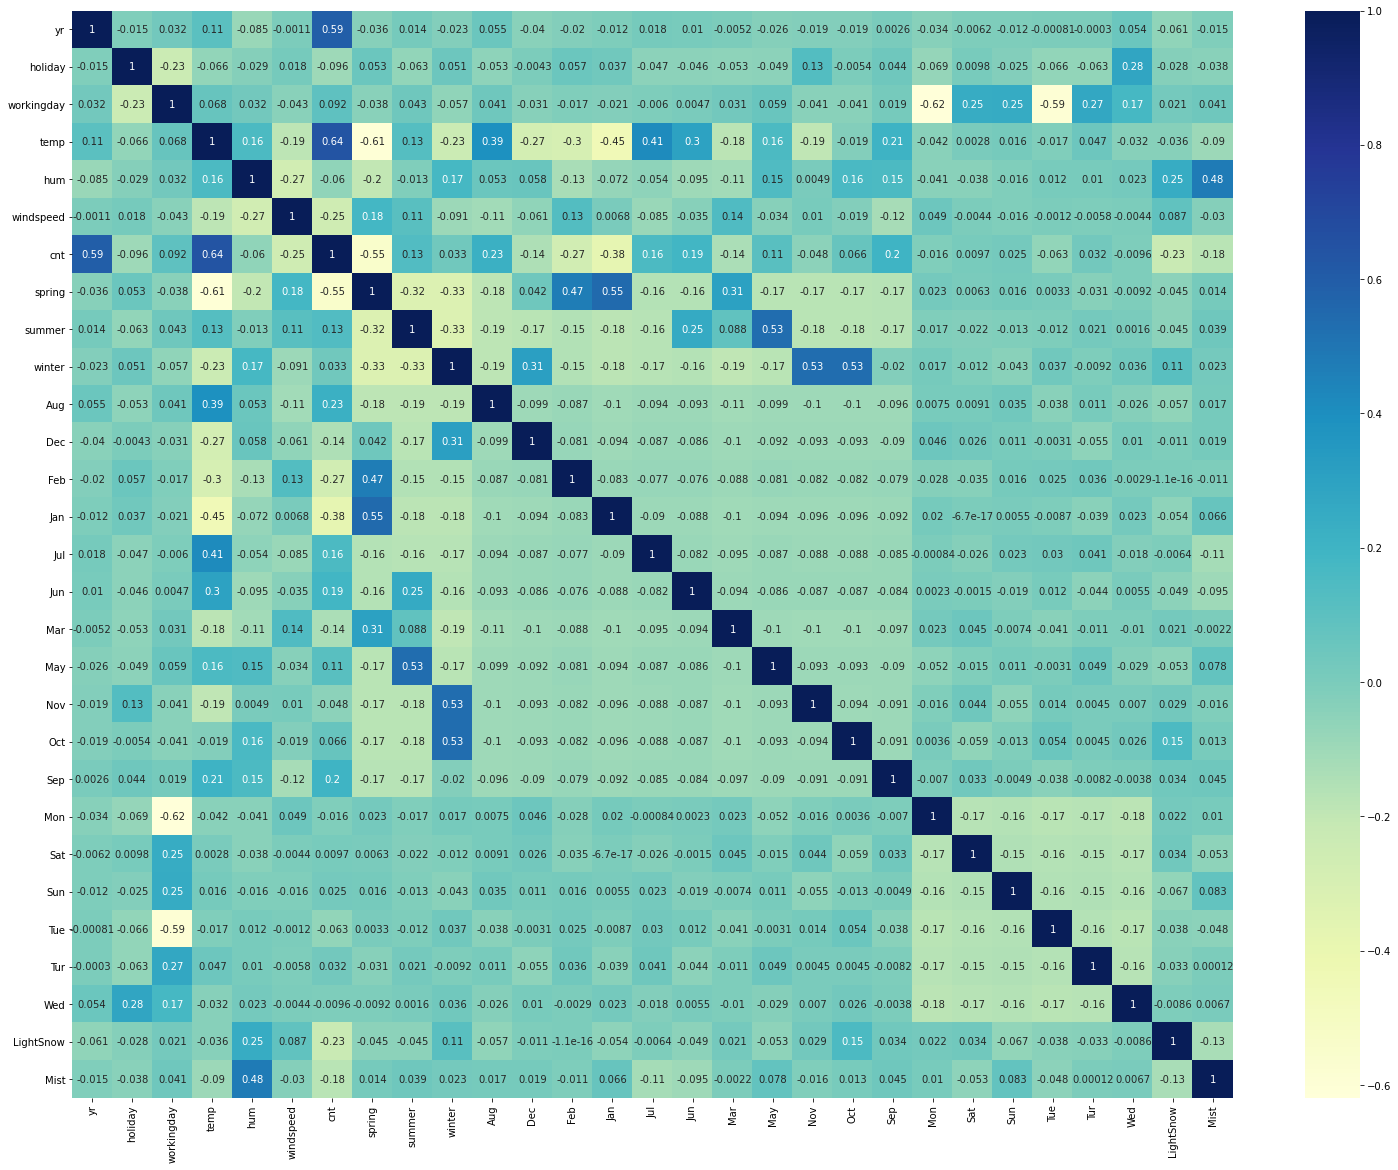

In [150]:
# Let's check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (26, 20))
sns.heatmap(df_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

#### Temp seems to be have the highest corelation to the cnt, let us check and do a pair plot

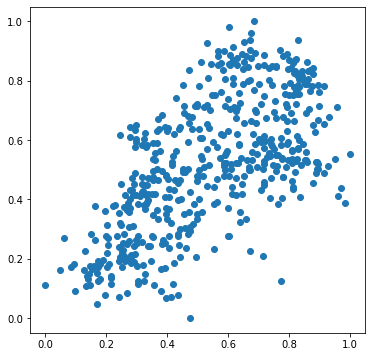

In [151]:
plt.figure(figsize=[6,6])
plt.scatter(df_train.temp, df_train.cnt)
plt.show()

##### Seems like a positive co-relation

### Dividing into X and Y sets for the model building

In [152]:
y_train = df_train.pop('cnt')
X_train = df_train

## Building our model

This time, we will be using the **LinearRegression function from SciKit Learn** for its compatibility with RFE (which is a utility from sklearn)

### RFE
Recursive feature elimination

In [153]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [154]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)
# Let us reduce from 29 to 15 variables and then use manual approach
rfe = RFE(lm, 15)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [155]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('Aug', False, 7),
 ('Dec', False, 3),
 ('Feb', False, 4),
 ('Jan', True, 1),
 ('Jul', True, 1),
 ('Jun', False, 13),
 ('Mar', False, 14),
 ('May', False, 5),
 ('Nov', False, 2),
 ('Oct', False, 10),
 ('Sep', True, 1),
 ('Mon', True, 1),
 ('Sat', False, 12),
 ('Sun', False, 11),
 ('Tue', False, 6),
 ('Tur', False, 9),
 ('Wed', False, 8),
 ('LightSnow', True, 1),
 ('Mist', True, 1)]

In [156]:
# The top 15 columns are:
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'spring',
       'summer', 'winter', 'Jan', 'Jul', 'Sep', 'Mon', 'LightSnow', 'Mist'],
      dtype='object')

In [157]:
# The ones that were eliminated by RFE are:
X_train.columns[~rfe.support_]

Index(['Aug', 'Dec', 'Feb', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sat', 'Sun',
       'Tue', 'Tur', 'Wed'],
      dtype='object')

### Building model using statsmodel, for the detailed statistics

In [158]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [159]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

In [160]:
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

In [161]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.6
Date:                Mon, 08 Mar 2021   Prob (F-statistic):          2.31e-191
Time:                        11:52:40   Log-Likelihood:                 519.88
No. Observations:                 510   AIC:                            -1008.
Df Residuals:                     494   BIC:                            -940.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2510      0.036      6.949      0.0

None of the columns have a p value greater that 0.05 which would have been easy to drop. So let us do VIF analysis to figure which ones to drop

In [162]:
X_train_new = X_train_rfe.drop(['const'], axis=1)

In [163]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Creating X_test dataframe with RFE selected variables
X = X_train_new

vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,hum,29.40
3,temp,17.77
2,workingday,5.31
5,windspeed,4.73
6,spring,4.53
8,winter,3.48
7,summer,2.84
14,Mist,2.29
0,yr,2.09
12,Mon,1.98


In [164]:
# hum has a very high VIF, let us drop it
X_train_new = X_train_rfe.drop(["hum"], axis = 1)
lm = sm.OLS(y_train,X_train_new).fit()   # Running the linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     190.3
Date:                Mon, 08 Mar 2021   Prob (F-statistic):          7.33e-189
Time:                        11:52:40   Log-Likelihood:                 511.16
No. Observations:                 510   AIC:                            -992.3
Df Residuals:                     495   BIC:                            -928.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1737      0.031      5.525      0.0

In [165]:
# Doing VIF again
# Creating X_test dataframe with RFE selected variables
X = X_train_new

vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,62.00
6,spring,5.03
4,temp,3.62
8,winter,3.45
7,summer,2.61
3,workingday,1.87
12,Mon,1.77
9,Jan,1.56
10,Jul,1.48
11,Sep,1.29


In [166]:
# Let us drop spring as it has a very high VIF = 5.03 > 5
X_train_new = X_train_new.drop(["spring"], axis = 1)
lm = sm.OLS(y_train,X_train_new).fit()   # Running the linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     201.4
Date:                Mon, 08 Mar 2021   Prob (F-statistic):          2.88e-188
Time:                        11:52:40   Log-Likelihood:                 506.98
No. Observations:                 510   AIC:                            -986.0
Df Residuals:                     496   BIC:                            -926.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1077      0.022      5.003      0.0

In [167]:
# Doing VIF again
# Creating X_test dataframe with RFE selected variables
X = X_train_new

vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,28.70
4,temp,1.93
3,workingday,1.87
11,Mon,1.77
8,Jan,1.54
7,winter,1.47
9,Jul,1.42
6,summer,1.41
10,Sep,1.19
2,holiday,1.16


#### Ended with 13 columns 
where the VIF is all under 2 and the largest p-values are for `holiday (0.036)` and `Jan (0.011)` and `Jul (0.038)`. These p-values are lower than 0.05 and so we can either DROP them or leave them in the model. I opt to leave it in the model

##### This is the final model
### R2 = 0.841 Adj. R2 = 0.837, F-statistic=201.4, Prob (F-statistic)=2.88e-188
### The Durbin-Watson:                   2.086 (which is close to 2, could be lower than 2)

## Residual Analysis of the train data

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [168]:
y_train_cnt = lm.predict(X_train_new)

In [169]:
# Importing the required libraries for plots.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 0, 'Errors')

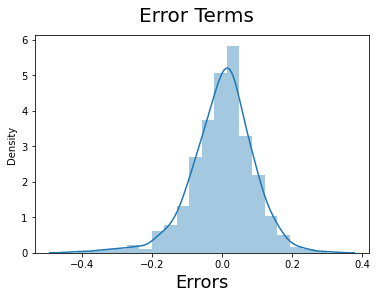

In [170]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

#### Error Analysis
Errors are all centered around ZERO and it is a normal distribution. Good!!!

In [171]:
df_test.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,spring,summer,winter,...,Oct,Sep,Mon,Sat,Sun,Tue,Tur,Wed,LightSnow,Mist
184,0,1,0,29.793347,63.7917,5.459106,6043,0,0,0,...,0,0,0,0,0,0,0,1,0,1
535,1,0,1,32.082500,59.2083,7.625404,6211,0,1,0,...,0,0,0,0,0,0,0,0,0,0
299,0,0,1,19.270000,81.2917,13.250121,2659,0,0,1,...,1,0,0,1,0,0,0,0,0,1
221,0,0,1,31.433347,42.4167,13.417286,4780,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152,0,0,1,29.315000,30.5000,19.583229,4968,0,1,0,...,0,0,0,1,0,0,0,0,0,0


## Making Predictions

#### Applying scaling on the columns 

In [172]:
num_vars = ['temp', 'hum', 'windspeed', 'cnt']

df_test[num_vars] = scaler.transform(df_test[num_vars])

#### Dividing into X_test and y_test

In [173]:
y_test = df_test.pop('cnt')
X_test = df_test
X_test.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'spring',
       'summer', 'winter', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar',
       'May', 'Nov', 'Oct', 'Sep', 'Mon', 'Sat', 'Sun', 'Tue', 'Tur', 'Wed',
       'LightSnow', 'Mist'],
      dtype='object')

In [174]:
X_train_new.columns

Index(['const', 'yr', 'holiday', 'workingday', 'temp', 'windspeed', 'summer',
       'winter', 'Jan', 'Jul', 'Sep', 'Mon', 'LightSnow', 'Mist'],
      dtype='object')

In [175]:
#Drop const from the X_train_new df
X_train_new = X_train_new.drop(["const"], axis = 1)

In [176]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [177]:
# Making predictions
y_test_pred = lm.predict(X_test_new)

## Model Evaluation

Text(0.5, 0, 'Errors')

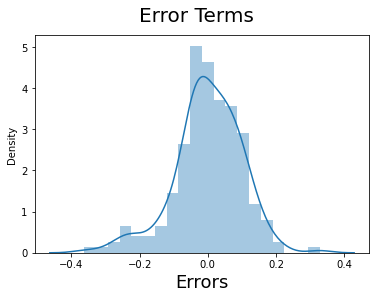

In [178]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_test - y_test_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

Text(0, 0.5, 'y_test_pred')

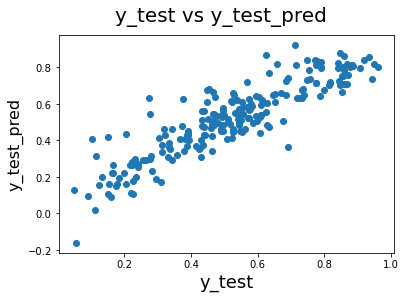

In [179]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_test_pred', fontsize=16)                          # Y-label

They seems to be following a linear treand, there are no clusters or a deviation to one side
or a bloom on either side of the fit line

In [180]:
# evalute
r2_score(y_true=y_test, y_pred=y_test_pred)

0.7932325267322773

#### We got a r2 squared of 80% on the test data, that is pretty good. We will keep this model.

#### Final Equation
cnt = 0.1077 + 0.2333 x yr - 0.0577 X holiday + 0.0471 X workingday + 0.5388 X temp 
     - 0.1627 X windspeed + 0.0725 X summer + 0.1168 X winter - 0.0450 X Jan
     - 0.0376 X jul + 0.0884 X Sep + 0.0591 X Mon - 0.2899 X LightSnow - 0.0818 X Mist
     
#### Look at the coefficients below
    0.2333   : yr 
    - 0.0577 : holiday 
    0.0471   : workingday 
    0.5388   : temp 
    - 0.1627 : windspeed 
    0.0725   : summer 
    0.1168   : winter 
    - 0.0450 : Jan
    - 0.0376 : jul 
    0.0884   : Sep 
    0.0591   : Mon 
    - 0.2899 : LightSnow 
    - 0.0818 : Mist

#### The company wants to know:

1. Which variables are significant in predicting the demand for shared bikes.
    -  See the list of Varibles in the above screen shot. These 13 variables are significant in determing the demand for Bike rentals in a growing market. `Temp` is the one with the highest coefficient, followed by `yr` (as populariy grows demand will grow year after year) and then `LightSnow`.


2. How well those variables describe the bike demands?
    -  Since we ended up with a r2_score of 80% on the test data, the model we came up with is fairly accurate and so the above variables and their coefficients can be accurately predict the demand for bike rentals

## Conclusion:
These 13 variables are significant in determing the demand for Bike rentals in a growing market. **Temp** is the one with the highest positive coefficient, followed by **yr** (as popularity grows demand will grow year after year) also with a strong positive coefficient and then followed by a slightly negative correlation with **LightSnow**.

#### What else could be done?

We could use derived variables, combine LightSnow+Mist+Clear to see if we can get a better variable to predict. There can be many such combinations.

Also, we could explore non-linear relationships for these variables.